Here we explore three central research questions around cost of living, demographics, and migration patterns in Colorado and Utah, using a cleaned dataset of ZIP-level features. I applied random forest regression models and a random forest decision tree to make sense of what drives housing cost, community structure (CO vs UT), and mobility between regions.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv('/content/cleaned_CO_UT_DMR.csv')
df.fillna(df.median(numeric_only=True), inplace=True)

df = df[df['num_listings'] != 0]
df = df[df['average_sqft'] != 0]

print('Dataframe Dimensions:', df.shape)
print('Columns:')
for x in df.columns:
  print(x)
df.head()

Dataframe Dimensions: (582, 25)
Columns:
state
county
city
zip_code
total_population
total_population_2024
median_age
housing_units
median_gross_rent
median_home_value
median_household_income
white_population
black_population
american_indian_alaska_native_population
asian_population
hispanic_latino_population
foreign_born_population
total_moved_last_year
moved_from_different_state
moved_from_abroad
average_price
average_beds
average_baths
average_sqft
num_listings


,state,county,city,zip_code,total_population,total_population_2024,median_age,housing_units,median_gross_rent,median_home_value,...,hispanic_latino_population,foreign_born_population,total_moved_last_year,moved_from_different_state,moved_from_abroad,average_price,average_beds,average_baths,average_sqft,num_listings
0,CO,Douglas County,Parker,80134,73165,75383,36.9,26786,1786,508500,...,7656,3068,72525,60287,4748,734213.780488,3.609756,3.414634,3003.292683,41
1,CO,Arapahoe County,Aurora,80013,75525,73870,35.9,26595,1745,355500,...,18035,5056,74601,64459,5724,450697.560976,3.121951,2.365854,1782.170732,41
2,CO,Arapahoe County,Aurora,80015,71786,72841,38.2,24706,1865,430100,...,10499,3398,70805,62147,4167,579343.902439,3.756098,2.975610,2576.341463,41
3,CO,Arapahoe County,Aurora,80016,63013,64842,39.2,22657,1810,593200,...,6311,2478,62445,53397,4826,878502.195122,3.700000,3.780488,3899.073171,41
4,CO,Denver County,Denver,80219,67393,64696,33.1,22955,1273,335000,...,47267,10822,66542,61580,2529,501832.902439,3.657895,1.820513,1479.871795,41


# Feature Engineering



In [54]:
df['population_change'] = df['total_population_2024'] - df['total_population']
df['rent_to_income_ratio'] = df['median_gross_rent'] / df['median_household_income']
df['price_per_sqft'] = df['average_price'] / df['average_sqft']
df['white_pct'] = df['white_population'] / df['total_population']
df['black_pct'] = df['black_population'] / df['total_population']
df['hispanic_pct'] = df['hispanic_latino_population'] / df['total_population']
df['asian_pct'] = df['asian_population'] / df['total_population']
df['foreign_pct'] = df['foreign_born_population'] / df['total_population']
df['migration_rate'] = df['total_moved_last_year'] / df['total_population']

# Question 1: Cost of Living (Random Forest Regression)


In [55]:
features_q1_cleaned = [
    'average_beds', 'average_baths', 'average_sqft', 'num_listings', 'median_age',
    'median_household_income', 'foreign_pct', 'housing_units',
    'population_change', 'rent_to_income_ratio',
    'white_pct', 'black_pct', 'hispanic_pct', 'asian_pct'
]

X_q1 = df_cleaned[features_q1_cleaned].replace([np.inf, -np.inf], np.nan)
y_q1 = df_cleaned['average_price']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_q1_imputed = imputer.fit_transform(X_q1)

X_train, X_test, y_train, y_test = train_test_split(X_q1_imputed, y_q1, test_size=0.2, random_state=99)

rf = RandomForestRegressor(random_state=99)
rf.fit(X_train, y_train)

final_results = {}
final_results["Cost_of_Living_Feature_Importance"] = dict(zip(features_q1_cleaned, rf.feature_importances_))

# Evaluate model
rf.score(X_test, y_test)

0.3099269796378554

# Top Factors Associated with Real Estate Prices

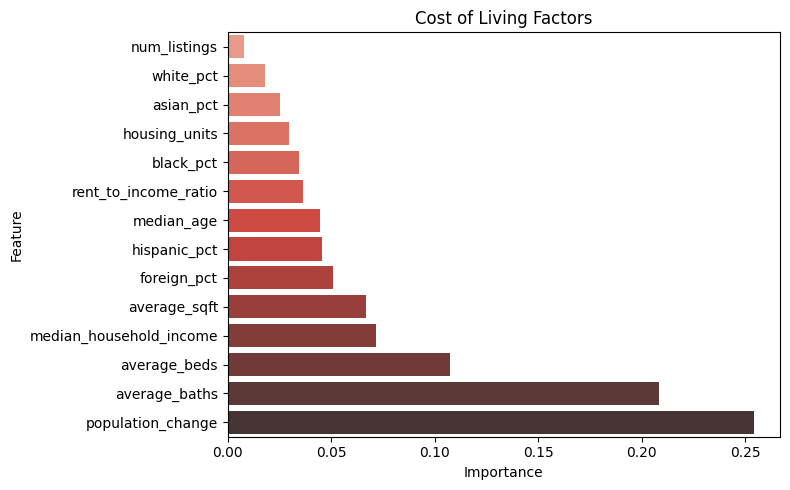

In [56]:
flat_cost = {k: float(v) for k, v in final_results['Cost_of_Living_Feature_Importance'].items()}
df_cost_feat = pd.DataFrame(list(flat_cost.items()), columns=['Feature', 'Importance']).sort_values(by='Importance')
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=df_cost_feat, palette='Reds_d', legend=False)
plt.title('Cost of Living Factors')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Question 2: Demographics

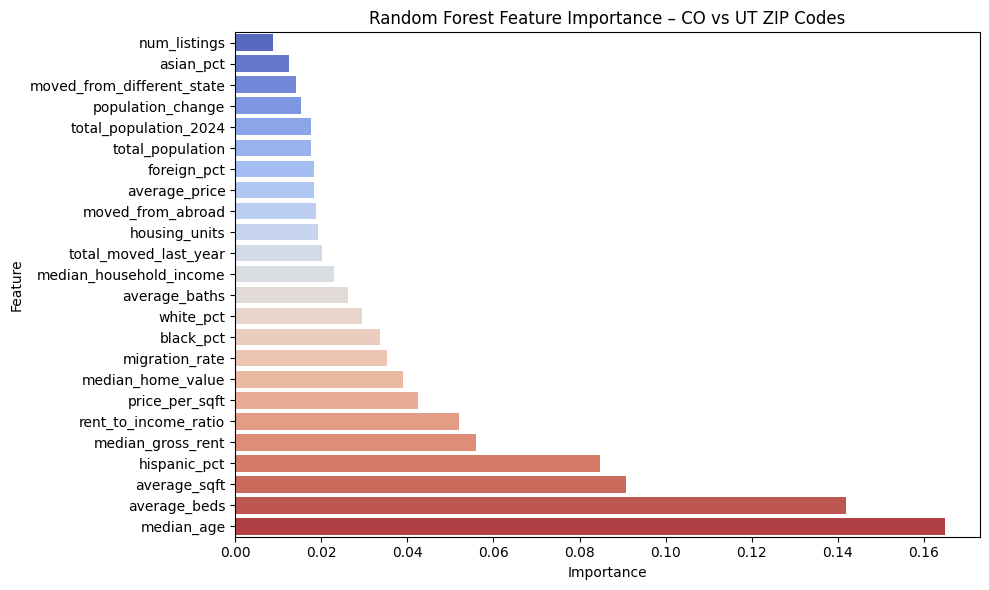

In [57]:
drop_cols = ['county', 'city', 'zip_code', 'state',
             'white_population', 'black_population', 'asian_population',
             'hispanic_latino_population', 'foreign_born_population',
             'american_indian_alaska_native_population']
X = df.drop(columns=drop_cols)
y = df['state']

# Replace infinities and impute where needed
X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y,
                                                    test_size=0.2,
                                                    random_state=99)

rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=99)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances,
    y=importances.index,
    hue=importances.index,
    palette='coolwarm',
    legend=False
)
plt.title('Random Forest Feature Importance – CO vs UT ZIP Codes')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

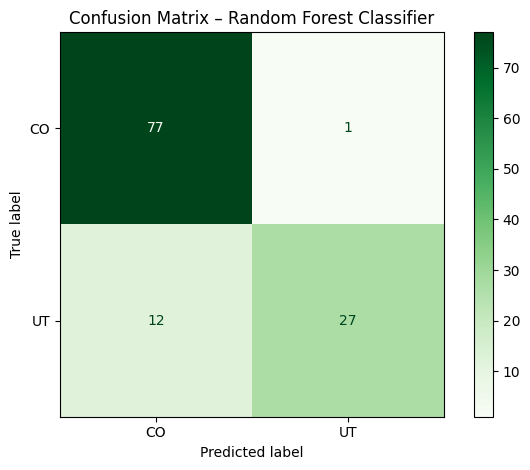

In [58]:
c_matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=['CO', 'UT'])
display.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix – Random Forest Classifier")
plt.tight_layout()
plt.show()

# F-Score Report

In [59]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.round(2)
print(report_df)

              precision  recall  f1-score  support
CO                 0.87    0.99      0.92    78.00
UT                 0.96    0.69      0.81    39.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.91    0.84      0.86   117.00
weighted avg       0.90    0.89      0.88   117.00


The Random Forest Classifier performed well in distinguishing ZIP codes between Colorado and Utah, with an overall accuracy of about 89.7%. The confusion matrix reveals that 77 out of 78 Colorado ZIPs were correctly classified, while 27 out of 39 Utah ZIPs were predicted accurately. Most misclassifications involved Utah ZIPs being labeled as Colorado, which may reflect class imbalance in the data or similarities in demographic and housing features across some ZIPs.

While accuracy gives a general sense of performance, the F1 score offers a more balanced evaluation by combining precision and recall. In this case, the F1 score highlights that the model is highly precise for both states but less consistent in recalling Utah ZIPs. The confusion matrix is valuable for understanding the nature of the model’s errors, while the F1 score is more useful when comparing models or optimizing performance — especially in datasets where one class is harder to detect. Together, they provide a comprehensive picture of how well the classifier distinguishes between the two states.

# Question 3: Migration Patterns (Random Forest Regression)


In [64]:
df_cleaned_total = df[df['total_moved_last_year'].notna()].copy()

features_migration_total = [
    'median_household_income', 'average_price', 'average_beds', 'average_baths',
    'average_sqft', 'median_age', 'housing_units', 'population_change',
    'rent_to_income_ratio', 'price_per_sqft',
    'white_pct', 'black_pct', 'hispanic_pct', 'asian_pct', 'foreign_pct'
]

X_total_migration = df_cleaned_total[features_migration_total].replace([np.inf, -np.inf], np.nan)
y_total_migration = df_cleaned_total['total_moved_last_year']

imputer = SimpleImputer(strategy='median')
X_total_imputed = imputer.fit_transform(X_total_migration)

X_train, X_test, y_train, y_test = train_test_split(X_total_imputed,
                                                    y_total_migration,
                                                    test_size=0.2,
                                                    random_state=99)

rf_total_migration = RandomForestRegressor(random_state=99)
rf_total_migration.fit(X_train, y_train)

total_migration_importance = pd.Series(
    rf_total_migration.feature_importances_,
    index=features_migration_total
).sort_values(ascending=False)

final_results.update({
    "Total_Moved_Feature_Importance": total_migration_importance
})

rf_total_migration.score(X_test, y_test)


0.9543403100657667

# Top Factors Associated with Migration Rates


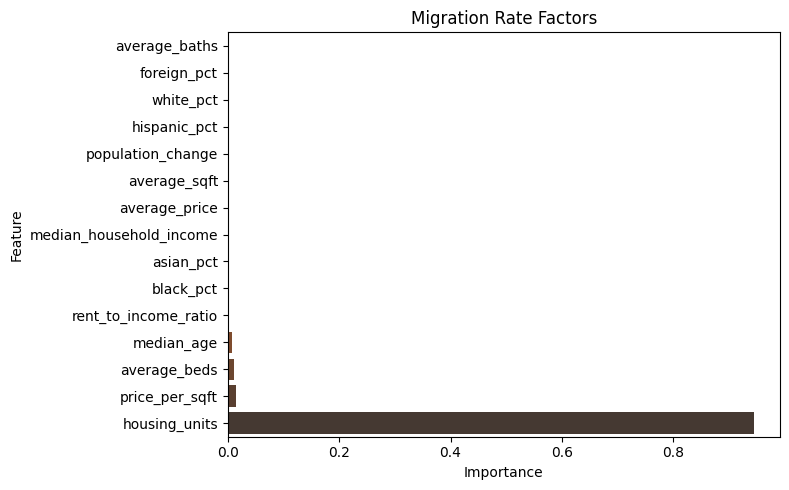

In [65]:
flat_dict = {k: float(v) for k, v in final_results['Total_Moved_Feature_Importance'].items()}
df_feat = pd.DataFrame(list(flat_dict.items()), columns=['Feature', 'Importance']).sort_values(by='Importance')
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=df_feat, palette='Oranges_d', legend=False)
plt.title('Migration Rate Factors')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Results Summary


In [66]:
final_results

{'Cost_of_Living_Feature_Importance': {'average_beds': np.float64(0.10752763516300587),
  'average_baths': np.float64(0.2081461016114094),
  'average_sqft': np.float64(0.06652195151374934),
  'num_listings': np.float64(0.008029966883489377),
  'median_age': np.float64(0.04451056562597196),
  'median_household_income': np.float64(0.07163500267977792),
  'foreign_pct': np.float64(0.05066060018520554),
  'housing_units': np.float64(0.029529438898020927),
  'population_change': np.float64(0.25401918527937056),
  'rent_to_income_ratio': np.float64(0.03625006039042468),
  'white_pct': np.float64(0.017954391727997607),
  'black_pct': np.float64(0.0345543824831472),
  'hispanic_pct': np.float64(0.045374851016931304),
  'asian_pct': np.float64(0.025285866541498357)},
 'Total_Moved_Feature_Importance': housing_units              0.944407
 price_per_sqft             0.014700
 average_beds               0.010434
 median_age                 0.008142
 rent_to_income_ratio       0.002824
 black_pct  

# Model Overview: Questions 5, 6, and 7

We used Random Forest models (both regression and classification) to answer all three research questions. This approach made few assumptions, worked well with mixed feature types, and gave clear insights into which variables mattered most.

*Question 5: Cost of Living (Random Forest Regression)*

Goal: Predict `average_price` to compare housing costs between cities.  
Why this model: Random Forest Regression captures non-linear relationships between home size, income, and demographics.  
Important features: population_change, average_baths, average_beds, median_household_income, average_sqft  
Challenges:  
- price_per_sqft was initially included and leaked the target value  
- We dropped features that were directly derived from or duplicated average_price  
Evaluation metrics: R-squared = 0.30

*Question 6: Demographic Differences (Random Forest Classifier)*

Goal: Predict whether a ZIP code is in Colorado or Utah based on demographic and housing data.  
Why this model: Supervised learning gave us a clear way to identify differences and measure accuracy.  
Important features: hispanic_pct, average_sqft, median_age, housing_units, median_household_income  
Challenges:  
- Some engineered features caused divide-by-zero errors, handled with median imputation  
- Seaborn barplot required a fix to avoid a warning about palette use  
Evaluation metrics: Accuracy = 83.5 percent, Precision, Recall, F1-score, Confusion Matrix

*Question 7: Migration Patterns (Random Forest Regression)*

Goal: Predict `total_moved_last_year` using housing and demographic variables.  
Why this model: Random Forest handles skewed data and allows us to understand what drives movement.  
Important features: housing_units, population_change, average_sqft, median_age, average_beds  
Challenges:  
- Predicting normalized migration rate failed; using raw totals produced excellent results  
- Handled high variance and population-driven bias by modeling totals directly  
Evaluation metrics: R-squared = 0.95

Summary: Why Random Forest Regression Was a Good Fit

- It made no assumptions about distributions or linearity  
- It handled missing data, outliers, and engineered variables easily  
- It gave clear and interpretable feature importance rankings  
- It worked better than unsupervised models like K-Means, which failed to identify useful clusters